In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as stats
import missingno as msno
from sklearn.impute import KNNImputer
from plotnine import ggplot, aes, geom_bar, geom_text, labs, theme_minimal
from datetime import datetime
from matplotlib_venn import venn2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import warnings
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE

In [2]:
# Display setting to better visualize notebook
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',10)
pd.set_option('display.width',1000)

In [3]:
# Read Train data
x_train_IP = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
x_train_OP =pd.read_csv('Train_Outpatientdata-1542865627584.csv')
x_train_BEN=pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
Y_train    =pd.read_csv('Train-1542865627584.csv')

In [69]:
x_train_IP['InscClaimAmtReimbursed'].sum()

408297020

In [73]:
x_train_OP['InscClaimAmtReimbursed'].sum()

148246120

In [4]:
x_train_IP.shape

(40474, 30)

In [5]:
x_train_OP.shape

(517737, 27)

In [6]:
x_train_BEN.shape

(138556, 25)

In [7]:
Y_train.shape

(5410, 2)

In [8]:
IP_columns= set(x_train_IP.columns)

In [9]:
OP_columns= set(x_train_OP.columns)

In [10]:
Common_columns_IO= IP_columns.intersection(OP_columns)

In [11]:
df_IO= pd.concat([x_train_IP,x_train_OP], ignore_index=True)

In [12]:
df_IO.shape

(558211, 30)

In [13]:
df_IOB=pd.merge(df_IO,x_train_BEN, on='BeneID', how='left')

In [14]:
df_IOB.shape

(558211, 54)

In [15]:
df_all= pd.merge(Y_train,df_IOB, on='Provider')

In [16]:
df_all.shape

(558211, 55)

In [17]:
# Aggratation to Provier leel
#Define a date format string and Convert date columns with a specified format
date_format = "%Y-%m-%d"
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']
for col in date_cols:
    if col in df_all.columns:
        df_all[col] = pd.to_datetime(df_all[col], format=date_format, errors='coerce')


In [18]:
# Convert Provider to string and # Convert all categorical columns to strings 
df_all['Provider'] = df_all['Provider'].astype(str)

cat_cols = df_all.select_dtypes(include=['object']).columns
df_all[cat_cols] = df_all[cat_cols].astype(str).fillna('Unknown')


In [19]:
# Mode function that avoids sorting errors
def mode_function(x):
    x = x.dropna().astype(str)  # Ensure all values are strings
    return x.mode().iat[0] if not x.mode().empty else 'Unknown'

In [20]:
# Define aggregation rules
agg_rules = {}
num_cols = df_all.select_dtypes(include=['number']).columns

for col in df_all.columns:
    if col in num_cols:
        agg_rules[col] = lambda x: round(x.mean(), 2)  # mean for numerical columns rounded to 2 decimals
    elif col in cat_cols and col != 'Provider':
        agg_rules[col] = mode_function  # Use fixed mode function
    elif col in date_cols:
        agg_rules[col] = 'min'  # Earliest date for datetime columns

In [21]:
# Aggregate data at Provider level
aggregated_data = df_all.groupby('Provider').agg(agg_rules).reset_index()

In [22]:
aggregated_data.shape

(5410, 55)

In [23]:
aggregated_data.isnull().sum()

Provider                    0
PotentialFraud              0
BeneID                      0
ClaimID                     0
ClaimStartDt                0
                           ..
ChronicCond_stroke          0
IPAnnualReimbursementAmt    0
IPAnnualDeductibleAmt       0
OPAnnualReimbursementAmt    0
OPAnnualDeductibleAmt       0
Length: 55, dtype: int64

In [24]:
aggregated_data.Provider.value_counts()

Provider
PRV51001    1
PRV55516    1
PRV55527    1
PRV55525    1
PRV55523    1
           ..
PRV53246    1
PRV53245    1
PRV53244    1
PRV53243    1
PRV57763    1
Name: count, Length: 5410, dtype: int64

In [25]:
aggregated_data

,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,PRV51001,No,BENE130029,CLM119495,2009-01-04,2009-01-04,4185.60,PHY350459,nan,nan,2009-02-03,nan,213.60,2009-02-06,nan,5168,nan,nan,nan,nan,nan,nan,nan,nan,nan,6090.00,2724.00,NaN,NaN,NaN,NaN,1911-10-01,NaT,1.64,1.16,0,1.00,460.00,12.00,12.00,1.40,1.24,1.32,1.80,1.60,1.64,1.16,1.08,1.76,1.68,1.76,17606.00,897.12,2615.20,463.92
1,PRV51003,Yes,BENE80174,CLM122012,2008-12-29,2009-01-06,4588.41,PHY364445,nan,nan,2008-12-29,nan,502.17,2009-01-07,nan,41401,nan,nan,nan,nan,nan,nan,nan,nan,nan,5460.85,3670.33,NaN,NaN,NaN,NaN,1912-12-01,2009-09-01,1.59,1.21,0,3.63,300.39,11.82,11.87,1.58,1.39,1.52,1.92,1.69,1.59,1.24,1.15,1.75,1.71,1.91,7568.18,931.42,2678.18,737.12
2,PRV51004,No,BENE133694,CLM117262,2009-01-03,2009-01-03,350.13,PHY394093,nan,nan,NaT,nan,2.08,NaT,nan,4019,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,1909-12-01,2009-07-01,1.69,1.23,0,12.40,327.18,11.87,11.96,1.57,1.41,1.66,1.89,1.72,1.58,1.30,1.28,1.67,1.69,1.89,4351.88,434.95,2194.90,622.75
3,PRV51005,Yes,BENE46215,CLM110739,2008-12-19,2009-01-01,241.12,PHY342753,nan,nan,NaT,nan,3.18,NaT,nan,4019,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,1909-01-01,2009-05-01,1.56,1.24,0,1.33,483.88,11.91,11.94,1.63,1.42,1.56,1.86,1.75,1.58,1.31,1.23,1.70,1.72,1.89,3623.99,379.16,2109.73,636.33
4,PRV51007,No,BENE12037,CLM112756,2009-01-01,2009-01-01,468.19,PHY380717,nan,nan,2009-03-15,nan,45.33,2009-03-22,nan,4019,nan,nan,nan,nan,nan,nan,nan,nan,nan,8627.00,NaN,NaN,NaN,NaN,NaN,1910-11-01,2009-05-01,1.53,1.19,0,3.00,375.42,11.83,11.83,1.64,1.44,1.69,1.83,1.78,1.60,1.32,1.29,1.71,1.69,1.83,3050.00,445.00,1729.72,469.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,BENE21957,CLM125801,2009-01-08,2009-01-13,380.00,PHY395799,nan,nan,NaT,nan,4.64,NaT,nan,4019,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,1920-07-01,NaT,1.43,1.64,0,45.00,361.07,12.00,12.00,1.50,1.29,1.46,1.86,1.61,1.68,1.29,1.00,1.54,1.68,1.86,3962.14,457.71,3241.79,886.79
5406,PRV57760,No,BENE23789,CLM138239,2009-01-15,2009-01-15,216.82,PHY379121,nan,nan,NaT,nan,0.00,NaT,nan,2722,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,1927-04-01,NaT,1.23,1.18,0,45.00,439.77,12.00,11.73,1.86,1.50,1.91,2.00,1.91,1.68,1.18,1.00,1.50,1.95,2.00,2785.45,436.91,1492.73,805.45
5407,PRV57761,No,BENE47990,CLM116841,2009-01-03,2009-01-05,225.24,PHY354815,nan,nan,NaT,nan,4.51,NaT,nan,4019,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,1910-12-01,2009-12-01,1.51,1.30,0,10.00,402.32,12.00,12.00,1.56,1.32,1.51,1.83,1.63,1.54,1.33,1.24,1.61,1.71,1.88,7026.59,586.10,2928.41,707.32
5408,PRV57762,No,BENE157252,CLM603185,2009-09-28,2009-09-28,1900.00,PHY432730,nan,nan,NaT,1748,0.00,NaT,nan,2330,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,1942-01-01,NaT,1.00,1.00,0,21.00,230.00,12.00,12.00,2.00,2.00,1.00,1.00,1.

In [101]:
# Save final_df as a CSV file
aggregated_data.to_csv("Aggregated_data_provider_level_csv", index=False)

Accuracy: 0.9094
Precision: 0.5405
Recall: 0.1980
F1-score: 0.2899
ROC-AUC: 0.8463
Confusion Matrix:
 [[964  17]
 [ 81  20]]


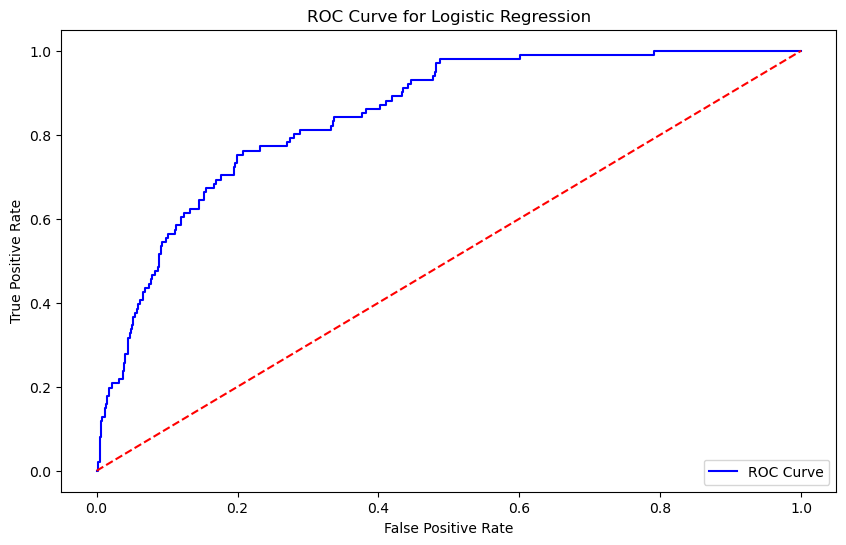

In [26]:
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with only NaN values
aggregated_data.dropna(axis=1, how='all', inplace=True)

#  Define features and target variable
X = aggregated_data.drop(columns=['PotentialFraud'])  
y = aggregated_data['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#  Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train Logistic Regression model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(max_iter=1000))])  

model.fit(X_train, y_train)

#  Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  

# Evaluate model performance with different classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Step 11: Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.9122
Precision: 0.5536
Recall: 0.3069
F1-score: 0.3949
ROC-AUC: 0.8402
Confusion Matrix:
 [[956  25]
 [ 70  31]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       981
           1       0.55      0.31      0.39       101

    accuracy                           0.91      1082
   macro avg       0.74      0.64      0.67      1082
weighted avg       0.90      0.91      0.90      1082



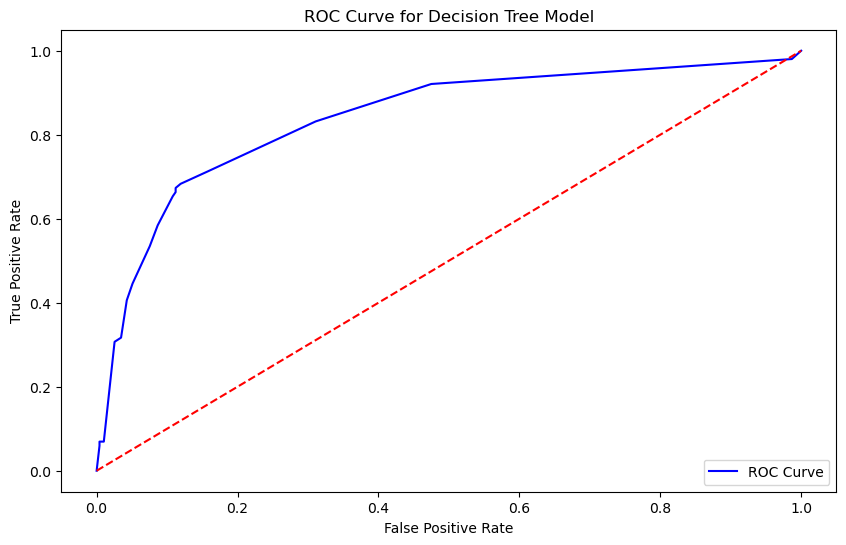

In [27]:
#  Replace infinities with NaN
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)

#  Drop columns with only NaN values
aggregated_data.dropna(axis=1, how='all', inplace=True)

#  Define features and target variable
X = aggregated_data.drop(columns=['PotentialFraud'])  
y = aggregated_data['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert target to numeric

#  Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train Decision Tree model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))])  

model.fit(X_train, y_train)

#  Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

#  Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Model')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.9205
Precision: 0.6087
Recall: 0.4158
F1-score: 0.4941
ROC-AUC: 0.9016
Confusion Matrix:
 [[954  27]
 [ 59  42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       981
           1       0.61      0.42      0.49       101

    accuracy                           0.92      1082
   macro avg       0.78      0.69      0.73      1082
weighted avg       0.91      0.92      0.91      1082



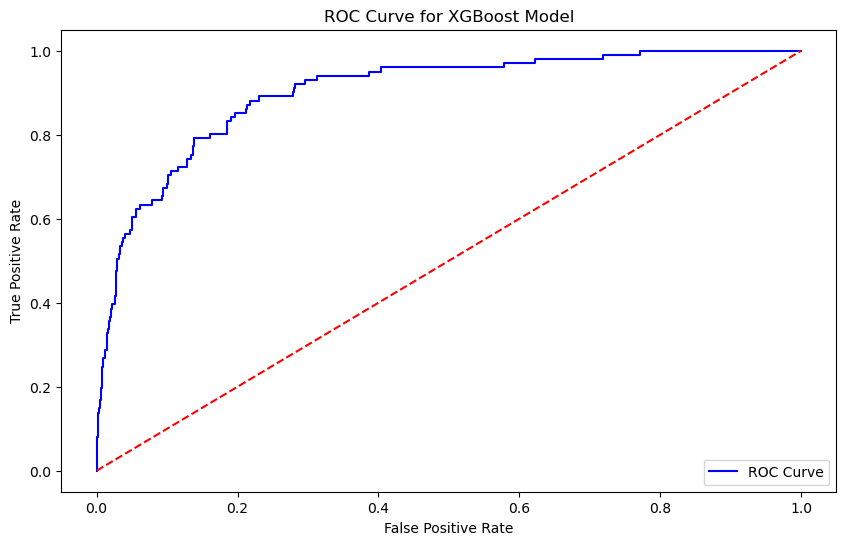

In [28]:
# Replace infinities with NaN
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)

#  Drop columns with only NaN values
aggregated_data.dropna(axis=1, how='all', inplace=True)

#  Define features and target variable
X = aggregated_data.drop(columns=['PotentialFraud'])  
y = aggregated_data['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert target to numeric

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

#  Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# : Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  Create and train XGBoost model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, 
                                                         objective='binary:logistic', eval_metric='logloss',
                                                         random_state=42))])  # Removed 'use_label_encoder'

model.fit(X_train, y_train)

#  Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  

#  Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

#  Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.show()

[LightGBM] [Info] Number of positive: 405, number of negative: 3923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3748
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093577 -> initscore=-2.270725
[LightGBM] [Info] Start training from score -2.270725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

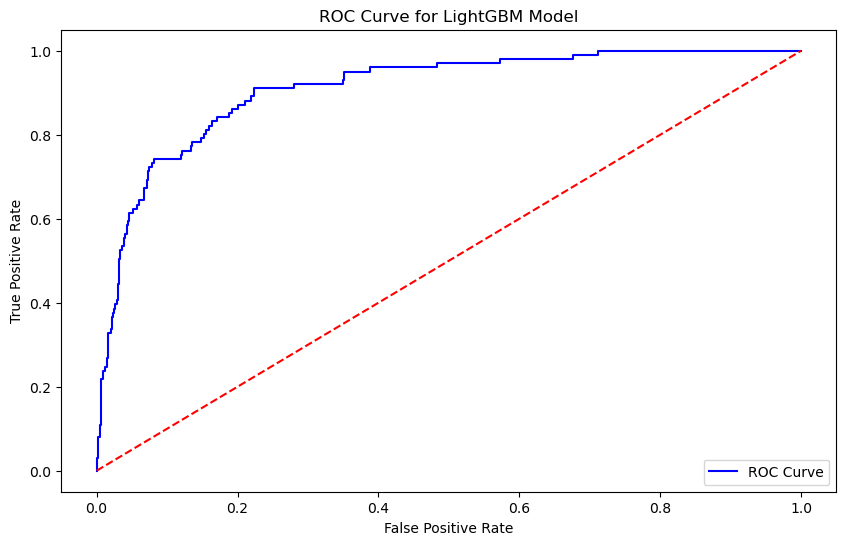

In [29]:
#  Replace infinities with NaN
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)

#  Drop columns with only NaN values
aggregated_data.dropna(axis=1, how='all', inplace=True)

#  Define features and target variable
X = aggregated_data.drop(columns=['PotentialFraud'])  
y = aggregated_data['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert target to numeric

#  Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Create and train LightGBM model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, 
                                                          objective='binary', random_state=42))])

model.fit(X_train, y_train)

# Step 9: Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  

# Step 10: Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

#  Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM Model')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.9233
Precision: 0.6957
Recall: 0.3168
F1-score: 0.4354
ROC-AUC: 0.9105
Confusion Matrix:
 [[967  14]
 [ 69  32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       981
           1       0.70      0.32      0.44       101

    accuracy                           0.92      1082
   macro avg       0.81      0.65      0.70      1082
weighted avg       0.91      0.92      0.91      1082



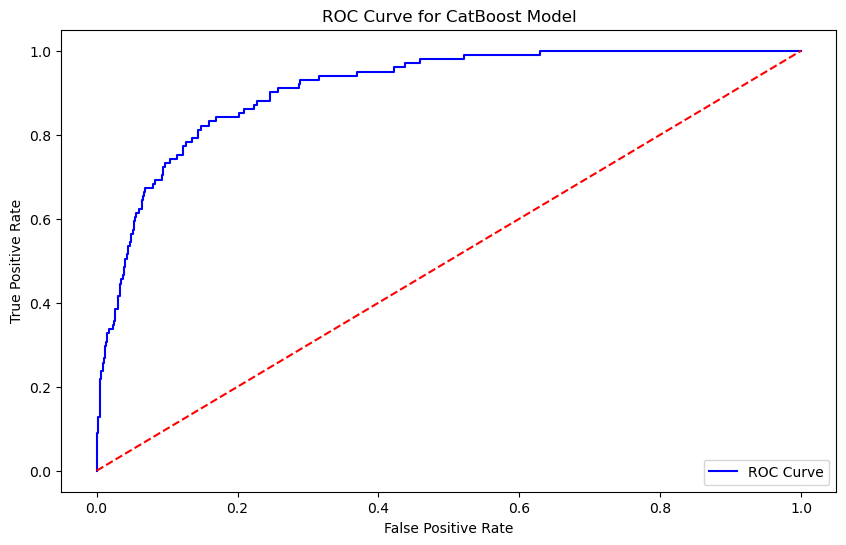

In [30]:
#  Replace infinities with NaN
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)

#  Drop columns with only NaN values
aggregated_data.dropna(axis=1, how='all', inplace=True)

#  Define features and target variable
X = aggregated_data.drop(columns=['PotentialFraud'])  
y = aggregated_data['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert target to numeric

#  Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

#  Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

#  Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  Create and train CatBoost model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', CatBoostClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, 
                                                          loss_function='Logloss', verbose=0, random_state=42))])

model.fit(X_train, y_train)

#  Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  

#  Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

#  Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost Model')
plt.legend(loc='lower right')
plt.show()